In [1]:
!pip install tensorflow

In [2]:
!pip install  tensorflow_datasets
!pip install  tensorflow_hub

In [4]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds

In [5]:
dataset, dataset_info = tfds.load('oxford_flowers102', with_info=True, as_supervised=True)
print(dataset_info)
test_set, training_set, validation_set = dataset['test'], dataset['train'], dataset['validation']

Dataset oxford_flowers102 downloaded and prepared to C:\Users\ysach\tensorflow_datasets\oxford_flowers102\2.1.1. Subsequent calls will reuse this data.
tfds.core.DatasetInfo(
    name='oxford_flowers102',
    full_name='oxford_flowers102/2.1.1',
    description="""
    The Oxford Flowers 102 dataset is a consistent of 102 flower categories commonly
    occurring in the United Kingdom. Each class consists of between 40 and 258
    images. The images have large scale, pose and light variations. In addition,
    there are categories that have large variations within the category and several
    very similar categories.
    
    The dataset is divided into a training set, a validation set and a test set. The
    training set and validation set each consist of 10 images per class (totalling
    1020 images each). The test set consists of the remaining 6149 images (minimum
    20 per class).
    
    Note: The dataset by default comes with a test size larger than the train size.
    For more

In [65]:
import json
with open('label_map.json', 'r') as f:
    class_names = json.load(f)

In [6]:
num_training_examples = 0
num_validation_examples = 0
num_test_examples = 0

for example in training_set:
  num_training_examples += 1

for example in validation_set:
  num_validation_examples += 1

for example in test_set:
  num_test_examples += 1

print('Total Number of Training Images: {}'.format(num_training_examples))
print('Total Number of Validation Images: {}'.format(num_validation_examples))
print('Total Number of Test Images: {} \n'.format(num_test_examples))
num_classes = dataset_info.features['label'].num_classes
print('Total Number of Classes of Flowers: {}'.format(num_classes))

Total Number of Training Images: 1020
Total Number of Validation Images: 1020
Total Number of Test Images: 6149 

Total Number of Classes of Flowers: 102


In [8]:
for i, example in enumerate(training_set.take(10)):
  print('Image {} shape: {} label: {}'.format(i+1, example[0].shape, example[1]))

Image 1 shape: (500, 667, 3) label: 72
Image 2 shape: (500, 666, 3) label: 84
Image 3 shape: (670, 500, 3) label: 70
Image 4 shape: (500, 505, 3) label: 51
Image 5 shape: (500, 672, 3) label: 48
Image 6 shape: (500, 761, 3) label: 83
Image 7 shape: (667, 500, 3) label: 42
Image 8 shape: (500, 672, 3) label: 58
Image 9 shape: (500, 667, 3) label: 40
Image 10 shape: (617, 500, 3) label: 35


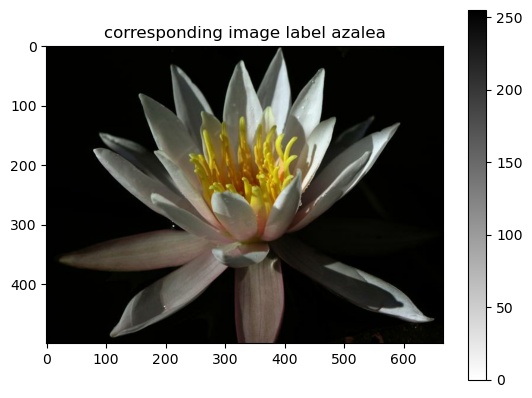

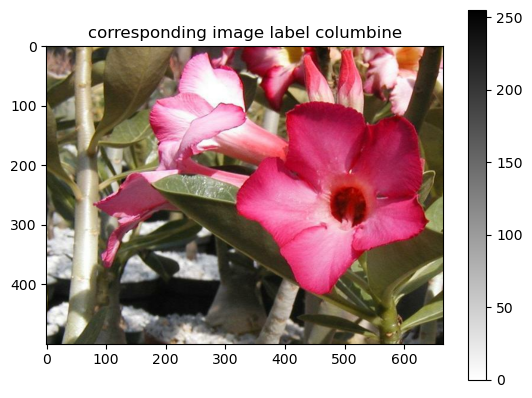

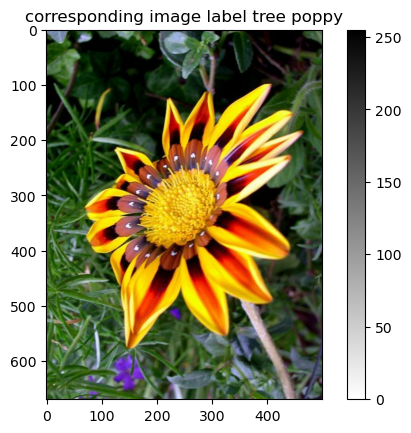

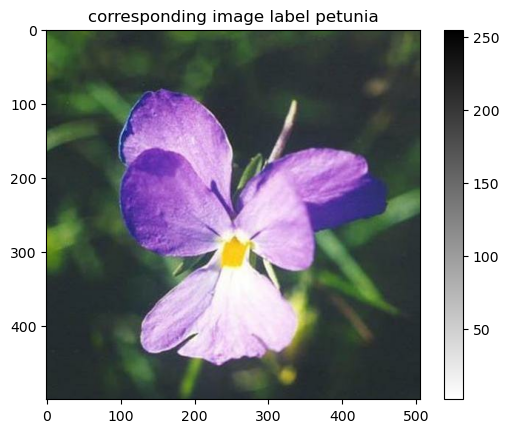

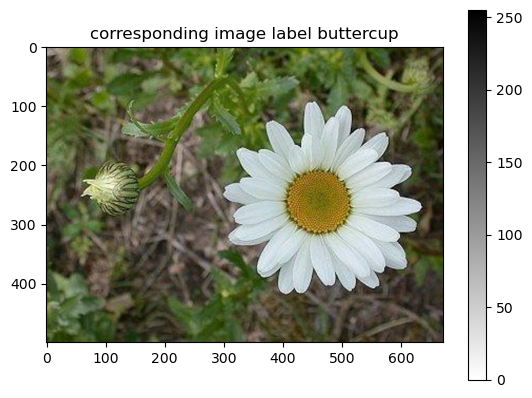

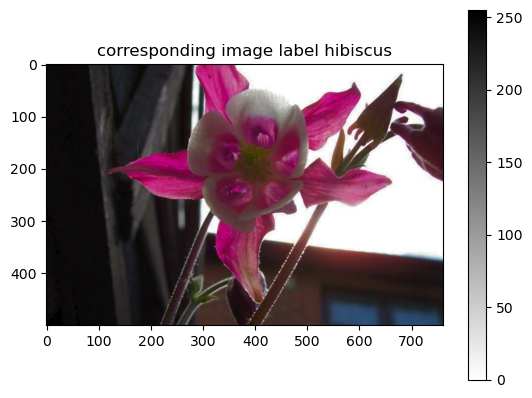

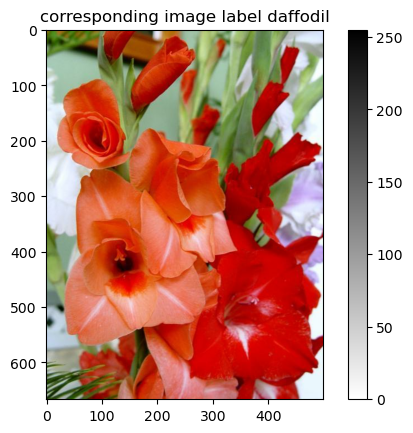

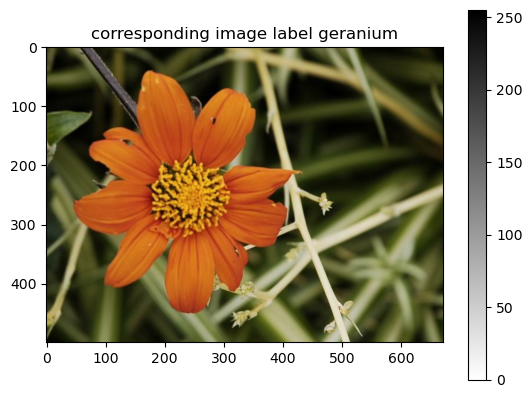

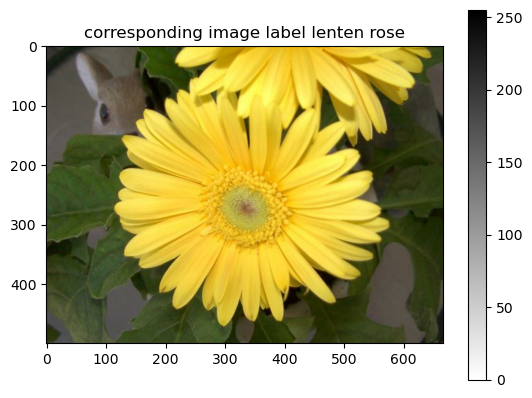

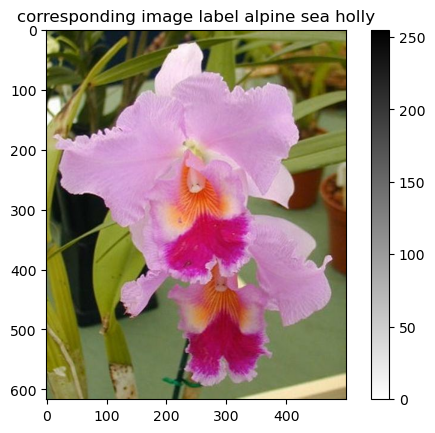

In [68]:
for image, label in training_set.take(10):
 image = image.numpy()
 plt.figure()
 plt.imshow(image, cmap=plt.cm.binary)
 plt.title('corresponding image label {}'.format(class_names[str(label.numpy())]))
 plt.colorbar()
 plt.grid(False)
 plt.show()

In [43]:
IMAGE_RES = 224

def format_image(image, label):
  image = tf.image.resize(image, (IMAGE_RES, IMAGE_RES))/255.0
  return image, label

BATCH_SIZE = 32

train_batches = training_set.cache().shuffle(num_training_examples//4).map(format_image).batch(BATCH_SIZE).prefetch(1)

validation_batches = validation_set.cache().map(format_image).batch(BATCH_SIZE).prefetch(1)

test_batches = test_set.cache().map(format_image).batch(BATCH_SIZE).prefetch(1)

In [44]:
#Using MobileNet
from tensorflow.keras import layers
URL = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"
feature_extractor = hub.KerasLayer(URL,
                                   input_shape=(IMAGE_RES, IMAGE_RES, 3))
feature_extractor.trainable = False
model = tf.keras.Sequential([
  feature_extractor,
  layers.Dense(num_classes, activation='softmax')
])

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_2 (KerasLayer)  (None, 1280)              2257984   
                                                                 
 dense_4 (Dense)             (None, 102)               130662    
                                                                 
Total params: 2388646 (9.11 MB)
Trainable params: 130662 (510.40 KB)
Non-trainable params: 2257984 (8.61 MB)
_________________________________________________________________


In [45]:
model.compile(
  optimizer='adam',
  loss='sparse_categorical_crossentropy',
  metrics=['accuracy'])

EPOCHS = 20

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=8)

history = model.fit(train_batches,
                    epochs=EPOCHS,
                    validation_data=validation_batches,
                    callbacks=[early_stopping])

Epoch 1/20
32/32 [==============================] - 54s 2s/step - loss: 4.2071 - accuracy: 0.1167 - val_loss: 3.0960 - val_accuracy: 0.3735
Epoch 2/20
32/32 [==============================] - 41s 1s/step - loss: 2.0268 - accuracy: 0.6951 - val_loss: 2.0134 - val_accuracy: 0.6382
Epoch 3/20
32/32 [==============================] - 37s 1s/step - loss: 1.0798 - accuracy: 0.9059 - val_loss: 1.5363 - val_accuracy: 0.7216
Epoch 4/20
32/32 [==============================] - 36s 1s/step - loss: 0.6562 - accuracy: 0.9676 - val_loss: 1.3044 - val_accuracy: 0.7657
Epoch 5/20
32/32 [==============================] - 36s 1s/step - loss: 0.4340 - accuracy: 0.9853 - val_loss: 1.1665 - val_accuracy: 0.7755
Epoch 6/20
32/32 [==============================] - 36s 1s/step - loss: 0.3128 - accuracy: 0.9941 - val_loss: 1.0823 - val_accuracy: 0.7853
Epoch 7/20
32/32 [==============================] - 36s 1s/step - loss: 0.2335 - accuracy: 0.9971 - val_loss: 1.0175 - val_accuracy: 0.8000
Epoch 8/20
32/32 [==

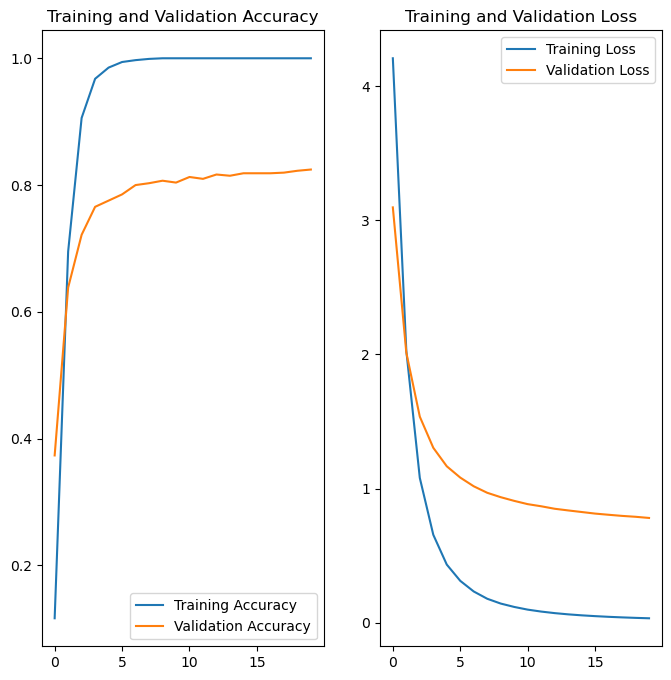

In [46]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [27]:
from tensorflow.keras.applications.resnet50 import ResNet50

In [47]:
resnet_model_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/classification/5"
feature_extractor1 = hub.KerasLayer(resnet_model_url,
                                   input_shape=(IMAGE_RES, IMAGE_RES, 3))
feature_extractor1.trainable = False

In [48]:
def format_image(image, label):
  image = tf.image.resize(image, (224, 224))/255.0
  image = tf.keras.applications.resnet50.preprocess_input(image)
  return image, label

BATCH_SIZE = 32

train_batches = training_set.cache().shuffle(num_training_examples//4).map(format_image).batch(BATCH_SIZE).prefetch(1)

validation_batches = validation_set.cache().map(format_image).batch(BATCH_SIZE).prefetch(1)

test_batches = test_set.cache().map(format_image).batch(BATCH_SIZE).prefetch(1)

In [49]:
model2 = tf.keras.Sequential([
  feature_extractor1,
  layers.Dense(num_classes, activation='softmax')
])

model2.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_3 (KerasLayer)  (None, 1001)              25615849  
                                                                 
 dense_5 (Dense)             (None, 102)               102204    
                                                                 
Total params: 25718053 (98.11 MB)
Trainable params: 102204 (399.23 KB)
Non-trainable params: 25615849 (97.72 MB)
_________________________________________________________________


In [50]:
model2.compile(
  optimizer='adam',
  loss='sparse_categorical_crossentropy',
  metrics=['accuracy'])

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=4)

history = model2.fit(train_batches,
                    epochs=6,
                    validation_data=validation_batches,
                    callbacks=[early_stopping])

Epoch 1/6
32/32 [==============================] - 84s 3s/step - loss: 7366.4780 - accuracy: 0.0069 - val_loss: 9683.8906 - val_accuracy: 0.0098
Epoch 2/6
32/32 [==============================] - 73s 2s/step - loss: 15311.1611 - accuracy: 0.0039 - val_loss: 22590.8887 - val_accuracy: 0.0098
Epoch 3/6
32/32 [==============================] - 71s 2s/step - loss: 28127.9766 - accuracy: 0.0088 - val_loss: 32738.6582 - val_accuracy: 0.0098
Epoch 4/6
32/32 [==============================] - 74s 2s/step - loss: 23657.9844 - accuracy: 0.0088 - val_loss: 16959.3027 - val_accuracy: 0.0098
Epoch 5/6
32/32 [==============================] - 72s 2s/step - loss: 13904.9141 - accuracy: 0.0069 - val_loss: 9810.3672 - val_accuracy: 0.0098


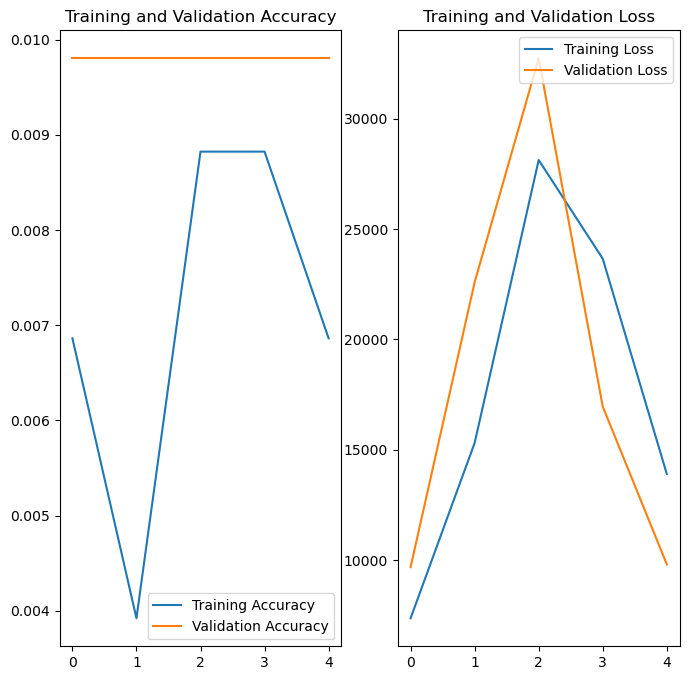

In [52]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(5)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
#resnet model is surely overfitting as seen here as it is much larger and suited for general object detection.Thus mobilenet is the best model to work with

In [53]:
def process_image(img):
    image = np.squeeze(img)
    image = tf.image.resize(image, (IMAGE_RES, IMAGE_RES))/255.0
    return image

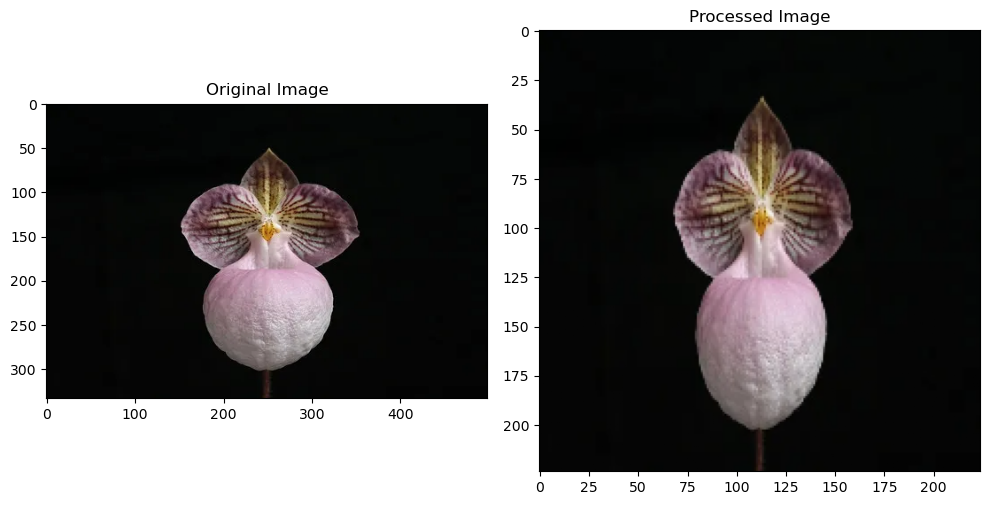

In [54]:
from PIL import Image

image_path = 'flower.webp'
im = Image.open(image_path)
test_image = np.asarray(im)

processed_test_image = process_image(test_image)

fig, (ax1, ax2) = plt.subplots(figsize=(10,10), ncols=2)
ax1.imshow(test_image)
ax1.set_title('Original Image')
ax2.imshow(processed_test_image)
ax2.set_title('Processed Image')
plt.tight_layout()
plt.show()

In [66]:
def predict(image_path, model, top_k):
    im = Image.open(image_path)
    test_image = np.asarray(im)
    processed_test_image = process_image(test_image)
    prediction = model.predict(np.expand_dims(processed_test_image, axis=0))
    top_values, top_indices = tf.math.top_k(prediction, top_k)
    print("These are the top propabilities",top_values.numpy()[0])
    top_classes = [class_names[str(value)] for value in top_indices.cpu().numpy()[0]]
    print('Of these top classes', top_classes)
    return top_values.numpy()[0], top_classes

1/1 [==============================] - 0s 57ms/step
These are the top propabilities [9.9509537e-01 1.9196436e-03 4.7463810e-04 2.9781158e-04 2.9295826e-04]
Of these top classes ['pink primrose', 'toad lily', 'camellia', 'balloon flower', 'pincushion flower']


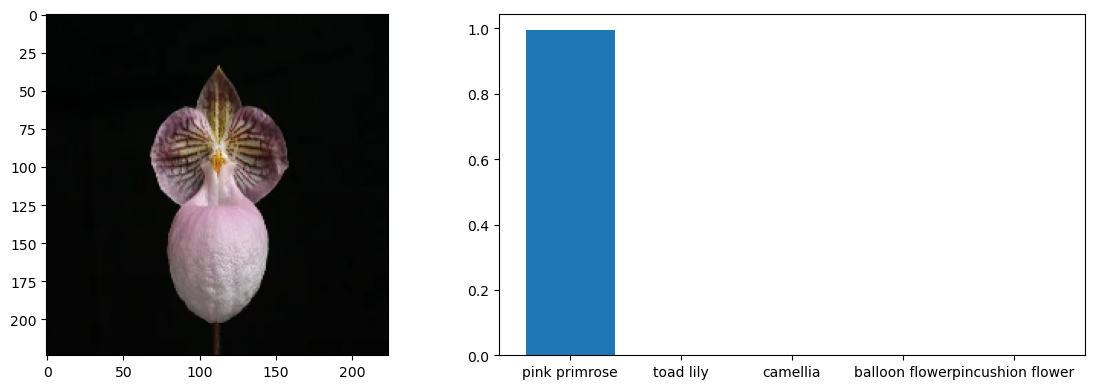

In [67]:
im = Image.open(image_path)
test_image = np.asarray(im)
processed_test_image = process_image(test_image)
probs, classes = predict(image_path, model, 5)
fig, (ax1, ax2) = plt.subplots(figsize=(12,4), ncols=2)
ax1.imshow(processed_test_image)
ax2 = plt.bar(classes, probs)
plt.tight_layout()
plt.show()